# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

# Librairies used

In [143]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from scipy.stats import norm, skew, kurtosis, jarque_bera
from arch import arch_model
from scipy.integrate import quad

# Data and calibration

In [144]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Close']
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


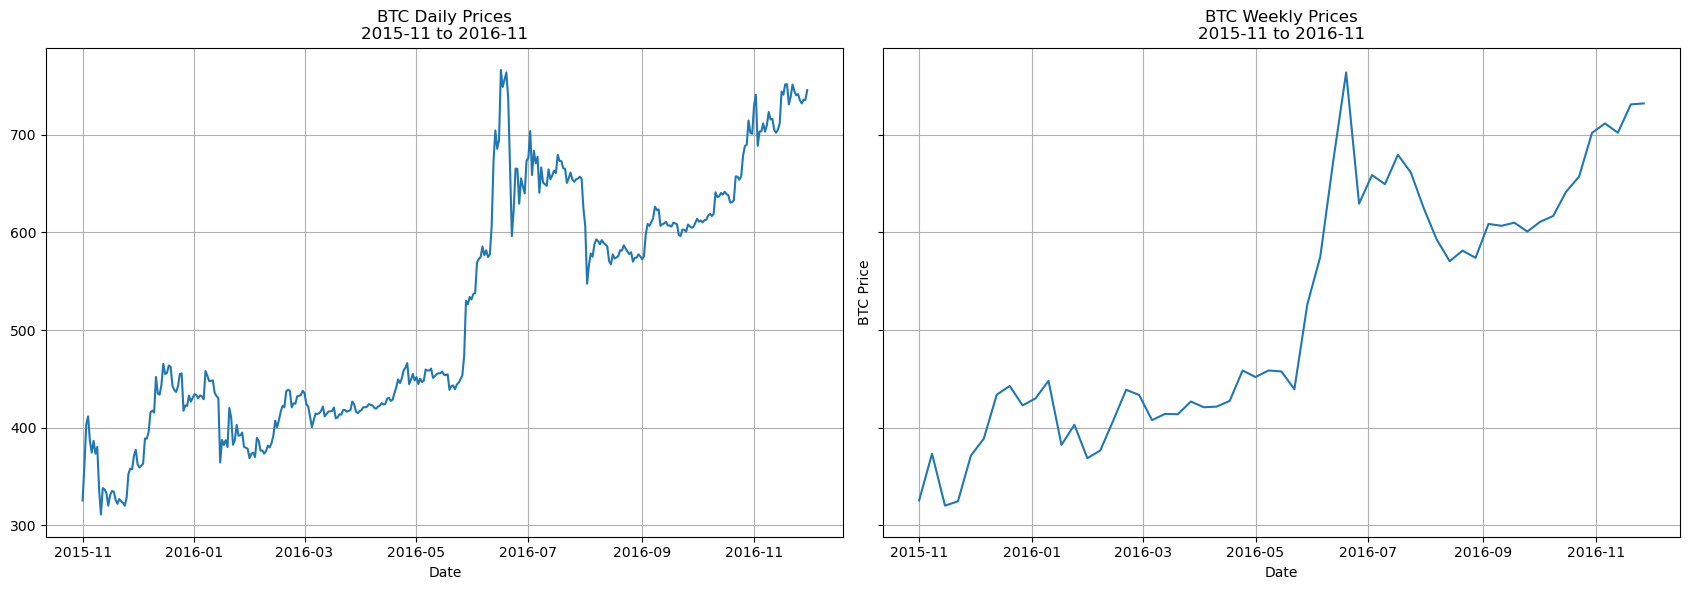

In [186]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

# Plot BTC Daily on the right subplot (ax1)
ax1.plot(btc_daily.loc[start_date:end_date])
ax1.set_xlabel('Date')
ax1.set_title('BTC Daily Prices\n{} to {}'.format(start_date, end_date))
ax1.grid(True)

# Plot BTC Weekly on the left subplot (ax2)
ax2.plot(btc_weekly.loc[start_date:end_date])
ax2.set_xlabel('Date')
ax2.set_ylabel('BTC Price')
ax2.set_title('BTC Weekly Prices\n{} to {}'.format(start_date, end_date))
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Parameters

Flat period: 2019-06 to 2020-06  
Bull market: 2020-10 to 2021-10  
Bear market: 2018-01 to 2019-01   
Low-vol market: 2023-07 to 2024-07  
High-vol market: 2015-11 to 2016-11

In [146]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions

In [179]:
start_date = '2015-11'
end_date = '2016-11'

btc_array = np.array(btc_daily.loc[start_date:end_date])
t_bill_array = np.array(t_bill_daily.loc[start_date:end_date])

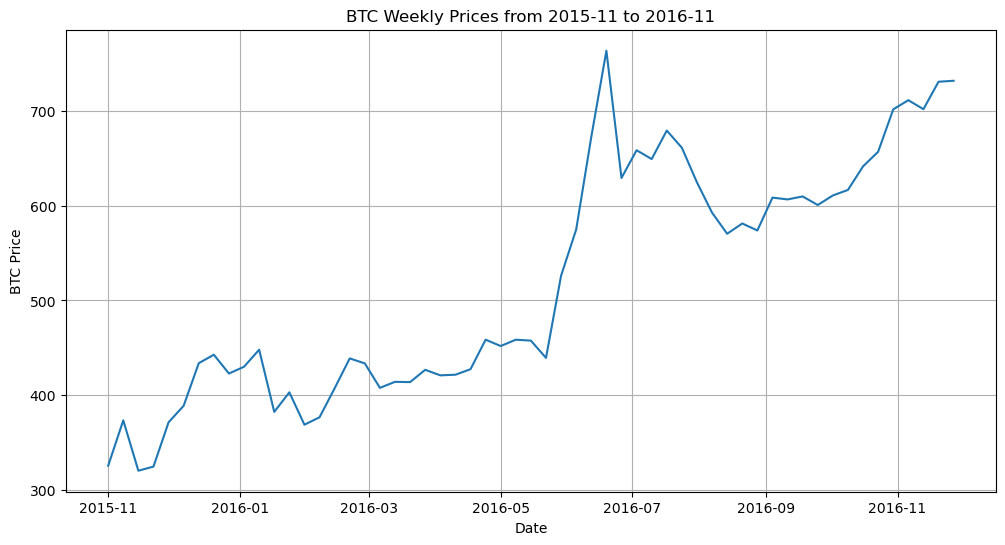

In [180]:
plt.figure(figsize=(12, 6))  
plt.plot(btc_weekly.loc[start_date:end_date])
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Weekly Prices from {} to {}'.format(start_date, end_date))
plt.grid(True)
plt.show()

# Volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 26773.842753863784
Iteration:      2,   Func. Count:     17,   Neg. LLF: 11722.65299193967
Iteration:      3,   Func. Count:     24,   Neg. LLF: 299701.69207676465
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11705.759921389734
Iteration:      5,   Func. Count:     39,   Neg. LLF: 10036.256132692324
Iteration:      6,   Func. Count:     44,   Neg. LLF: 10035.057106653156
Iteration:      7,   Func. Count:     49,   Neg. LLF: 10034.997395124461
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10034.99543845086
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10034.995398012334
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10034.995388912015
Iteration:     11,   Func. Count:     68,   Neg. LLF: 10034.99538891192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10034.995388912015
            Iterations: 11
            Function evaluations: 68
            Gradient evalua

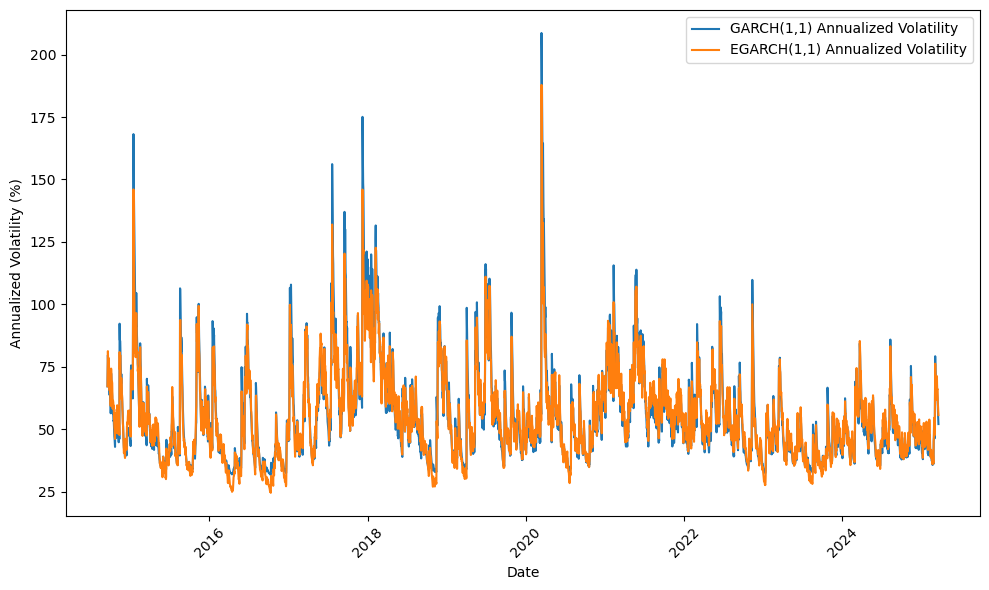

In [149]:
# Step 1: Calculate the weekly returns (percentage change)
btc_returns = btc_daily.pct_change().dropna()

# Step 2: Rescale the returns to improve convergence (scale by 100)
scaled_returns = btc_returns * 100

# Step 3: Fit the GARCH(1,1) model to the rescaled returns
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

# Step 4: Extract the GARCH volatility (conditional standard deviation)
garch_volatility = garch_fit.conditional_volatility

# Step 5: Rescale the GARCH volatility back to the original scale
garch_volatility = garch_volatility / 100

# Step 6: Annualize the GARCH volatility (assuming 52 weeks per year)
garch_annualized_volatility = garch_volatility * np.sqrt(252)

# Step 7: Fit the EGARCH(1,1) model to the rescaled returns
egarch_model = arch_model(scaled_returns, vol='EGARCH', p=1, q=1)
egarch_fit = egarch_model.fit()

# Step 8: Extract the EGARCH volatility (conditional standard deviation)
egarch_volatility = egarch_fit.conditional_volatility

# Step 9: Rescale the EGARCH volatility back to the original scale
egarch_volatility = egarch_volatility / 100

# Step 10: Annualize the EGARCH volatility (assuming 52 weeks per year)
egarch_annualized_volatility = egarch_volatility * np.sqrt(252)

# Step 11: Plot both GARCH and EGARCH annualized volatilities on the same graph
plt.figure(figsize=(10, 6))
plt.plot(btc_returns.index, garch_annualized_volatility*100, label='GARCH(1,1) Annualized Volatility')
plt.plot(btc_returns.index, egarch_annualized_volatility*100, label='EGARCH(1,1) Annualized Volatility')
#plt.title('Annualized Volatility (GARCH(1,1) vs EGARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

# Optionally, print the model summaries
#print(garch_fit.summary())
#print(egarch_fit.summary())

In [176]:
# search for highest and lowest volatility periods for both models
highest_volatility = garch_annualized_volatility.rolling(window=252).mean().max()
highest_volatility_date = garch_annualized_volatility.rolling(window=252).mean().idxmax()
print('GARCH:')
print('Highest 1-Year Rolling Mean Volatility:', highest_volatility)
print('Date of Highest 1-Year Rolling Mean Volatility:', highest_volatility_date)
print('')
lowest_volatility = garch_annualized_volatility.rolling(window=252).mean().min()
lowest_volatility_date = garch_annualized_volatility.rolling(window=252).mean().idxmin()
print('Lowest 1-Year Rolling Mean Volatility:', lowest_volatility)
print('Date of Lowest 1-Year Rolling Mean Volatility:', lowest_volatility_date)
print('')

print('EGARCH:')
highest_volatility = egarch_annualized_volatility.rolling(window=252).mean().max()
highest_volatility_date = egarch_annualized_volatility.rolling(window=252).mean().idxmax()
print('Highest 1-Year Rolling Mean Volatility:', highest_volatility)
print('Date of Highest 1-Year Rolling Mean Volatility:', highest_volatility_date)
print('')
lowest_volatility = egarch_annualized_volatility.rolling(window=252).mean().min()
lowest_volatility_date = egarch_annualized_volatility.rolling(window=252).mean().idxmin()
print('Lowest 1-Year Rolling Mean Volatility:', lowest_volatility)
print('Date of Lowest 1-Year Rolling Mean Volatility:', lowest_volatility_date)


GARCH:
Highest 1-Year Rolling Mean Volatility: 0.8598458747255662
Date of Highest 1-Year Rolling Mean Volatility: 2018-03-24 00:00:00

Lowest 1-Year Rolling Mean Volatility: 0.4140758854463219
Date of Lowest 1-Year Rolling Mean Volatility: 2023-12-11 00:00:00

EGARCH:
Highest 1-Year Rolling Mean Volatility: 0.8099615970410868
Date of Highest 1-Year Rolling Mean Volatility: 2018-03-24 00:00:00

Lowest 1-Year Rolling Mean Volatility: 0.4041746669694262
Date of Lowest 1-Year Rolling Mean Volatility: 2016-11-03 00:00:00


**Discrepancy between the two models for the lowest volatility period.**

# Backtesting Portfolio Insurance

## CPPI

### Run the strategy

In [151]:
def cppi_strategy(risky_asset, riskless_asset, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_asset (array-like): Prices of the risk-free asset (e.g., T-Bill).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing DataFrames for each (multiplier, floor_fraction) combination.
    """
    # Convert into arrays
    risky_asset = np.asarray(risky_asset)
    riskless_asset = np.asarray(riskless_asset)

    # Ensure same length
    if len(risky_asset) != len(riskless_asset):
        raise ValueError("The lengths of risky_asset and riskless_asset must be the same.")

    dates = btc_daily.loc[start_date:end_date].index  # Adjust as per data 

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialization
            floor = initial_portfolio_value * floor_fraction
            cushion = max(initial_portfolio_value - floor, 0) / initial_portfolio_value

            risky_w = max(multiplier * cushion, 0)
            riskless_w = 1 - risky_w

            risky_weights = [risky_w]
            riskless_weights = [riskless_w]
            basket_values = [initial_portfolio_value]

            for i in range(1, len(risky_asset)):
                # returns
                risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
                riskless_return = ((1 + riskless_asset[i] / 100) ** (1 / 252)) - 1  # Adjust as needed (52 for weekly, 252 for daily)

                # Update portfolio value
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value = basket_values[i - 1] * (1 + portfolio_return)

                # Update weights
                cushion = max(basket_value - floor, 0) / basket_value

                risky_w = multiplier * cushion
                risky_w = max(risky_w, 0)  # Ensure the risky allocation is non-negative

                # risk-free allocation
                riskless_w = 1 - risky_w

                # Append the results
                risky_weights.append(risky_w)
                riskless_weights.append(riskless_w)
                basket_values.append(basket_value)

            # Convert results to a DataFrame and set the index to the dates of the risky asset
            cppi_df = pd.DataFrame({
                'Basket Value': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights
            }, index=dates)  # Use all dates

            # Store the DataFrame in the results dictionary
            results[(multiplier, floor_fraction)] = cppi_df

    return results

In [152]:
# Run CPPI strategy for all combinations
cppi_results = cppi_strategy(btc_array, t_bill_array, multipliers, floor_fractions, initial_portfolio_value)

# Access results for a specific combination
cppi_results[(6, 0.9)].head() # Multiplier, Floor Fraction

,Basket Value,Risky Weights,Risk-Free Weights
Date,,,
2018-01-01,100000,0.6,0.4
2018-01-02,[105822.83579202012],[0.8971316449949052],[0.10286835500509484]
2018-01-03,[107210.52888854578],[0.9631812696178872],[0.03681873038211281]
2018-01-04,[109915.78879525502],[1.0871480256045676],[-0.08714802560456758]
2018-01-05,[123935.93821310865],[1.6429102987749484],[-0.6429102987749484]


### Analysis

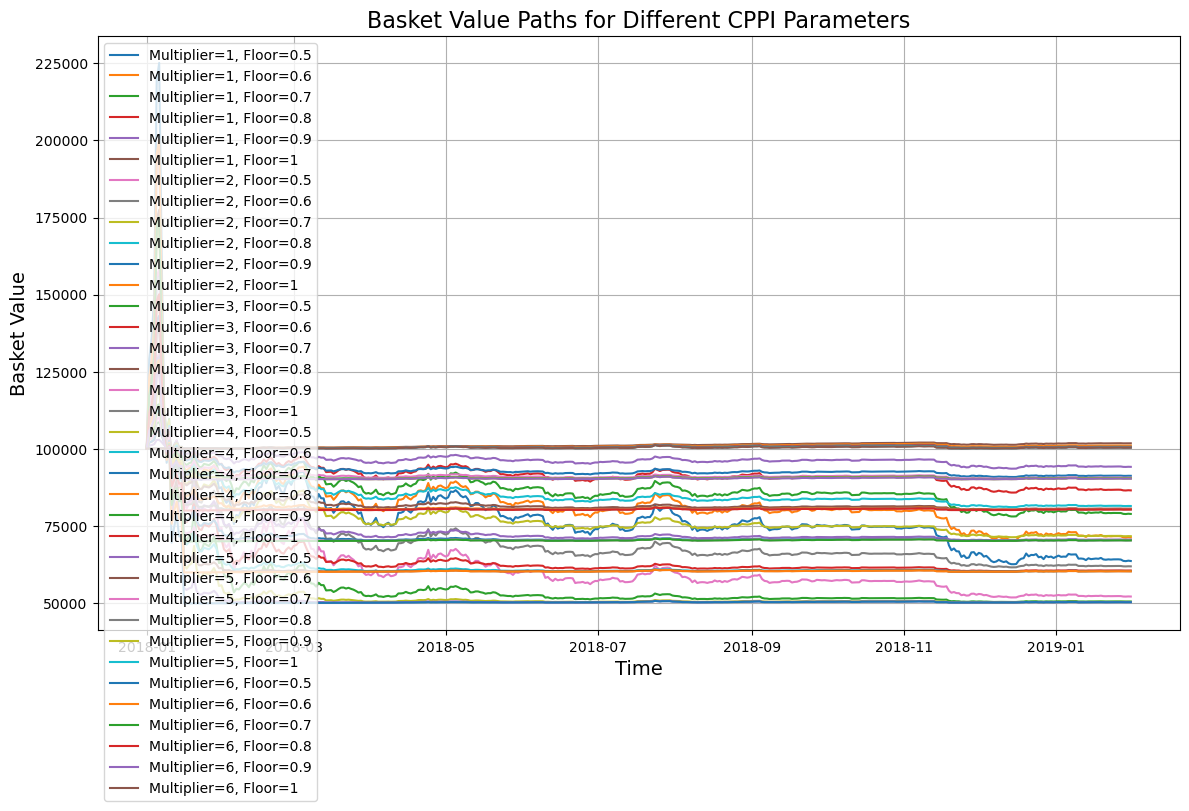

In [153]:
def plot_basket_values(results):
    """
    Plots all the basket value paths for different combinations of multiplier and floor_fraction.

    Parameters:
        results (dict): Dictionary containing DataFrames for each (multiplier, floor_fraction) combination.
    """
    plt.figure(figsize=(12, 8))
    
    for (multiplier, floor_fraction), df in results.items():
        plt.plot(df.index, df['Basket Value'], label=f'Multiplier={multiplier}, Floor={floor_fraction}')
    
    plt.title("Basket Value Paths for Different CPPI Parameters", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Basket Value", fontsize=14)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_basket_values(cppi_results)

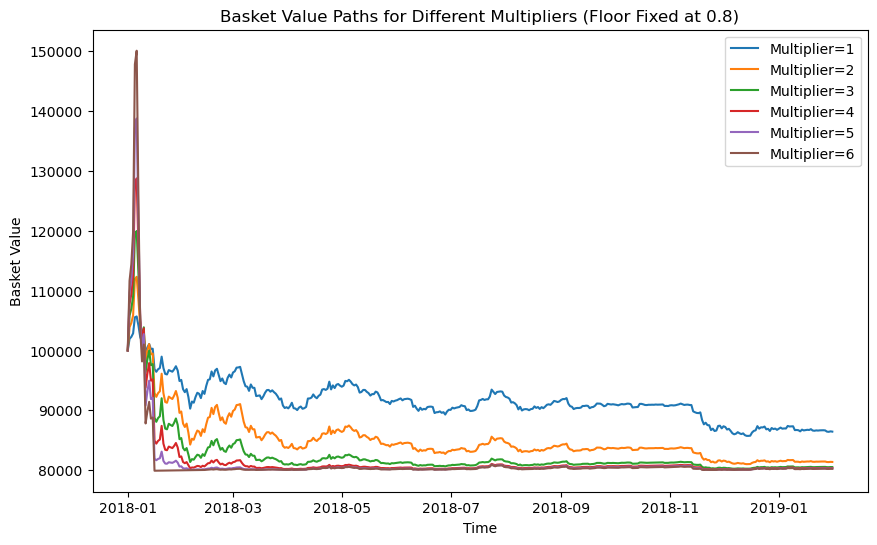

In [174]:
# Plot with one floor fixed
fixed_floor = 0.8

plt.figure(figsize=(10, 6))

# Filter and plot only results with the fixed floor
for key, df in cppi_results.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor = key
    else:
        continue  # Skip if key format is unexpected

    # Plot only if the floor matches the fixed floor
    if floor == fixed_floor:
        plt.plot(df.index, df['Basket Value'], label=f'Multiplier={multiplier}')

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title(f'Basket Value Paths for Different Multipliers (Floor Fixed at {fixed_floor})')
plt.legend()
plt.show()

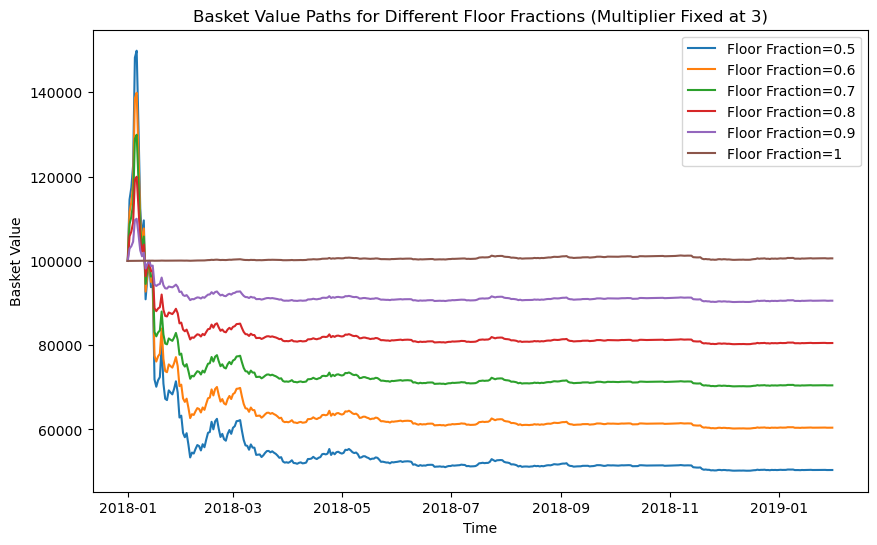

In [175]:
# Plot with multiplier fixed
fixed_multiplier = 3

plt.figure(figsize=(10, 6))

# Filter and plot only results with the fixed multiplier
for key, df in cppi_results.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor_fraction = key
    else:
        continue  # Skip if key format is unexpected

    # Plot only if the multiplier matches the fixed multiplier
    if multiplier == fixed_multiplier:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction}')

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title(f'Basket Value Paths for Different Floor Fractions (Multiplier Fixed at {fixed_multiplier})')
plt.legend()
plt.show()

In [156]:
# Find the best combination wrt final value

max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (multiplier, floor_fraction), df in cppi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (multiplier, floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Multiplier = {best_params[0]}, Floor Fraction = {best_params[1]}")

Maximum Basket Value: [101715.97333084]
Best Parameters: Multiplier = 1, Floor Fraction = 1


## OBPI

### Run the strategy

In [157]:
def obpi_strategy(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (array-like or pd.Series): Prices of the risky asset (e.g., BTC).
        riskless_rate (array-like or pd.Series): Annualized risk-free rates (e.g., T-Bill rates in %), same length as risky_asset.
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float): Volatility of the risky asset (annualized).

    Returns:
        dict: Dictionary containing DataFrames for each floor_fraction.
    """
    
    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Convert inputs to NumPy arrays if they are not pandas Series
    if isinstance(risky_asset, pd.Series):
        risky_asset = risky_asset.values

    if isinstance(riskless_rate, pd.Series):
        riskless_rate = riskless_rate.values

    # Ensure inputs have the same length
    if len(risky_asset) != len(riskless_rate):
        raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")

    results = {}
    dt = 1 / 252  # Weekly time step in years

    dates = btc_daily.loc[start_date:end_date].index  # Adjust as per data 

    for floor_fraction in floor_fractions:
        # Initialization
        floor = initial_portfolio_value * floor_fraction

        # Calculate put option price and delta
        put_price, put_delta = black_scholes_put(risky_asset[0], risky_asset[0]*floor_fraction, time_to_maturity, riskless_rate[0] / 100, sigma.iloc[0])

        # Update weights based on OBPI formula
        risky_w = ((1 + put_delta) * risky_asset[0]) / (risky_asset[0] + put_price)

        # Ensure weights are within bounds
        risky_w = max(0, min(1, risky_w))
        riskless_w = 1 - risky_w

        # Initialize lists to store results
        risky_weights = [risky_w]
        riskless_weights = [riskless_w]
        basket_values = [initial_portfolio_value]

        put_prices = [put_price]
        put_deltas = [put_delta]

        # Loop over each time step
        for i in range(1, len(risky_asset)):
            # Update remaining time to maturity
            remaining_ttm = time_to_maturity - i * dt

            # Calculate returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
            riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 252)) - 1  # Weekly compounding

            # Update portfolio value
            portfolio_return = risky_w * risky_return + riskless_w * riskless_return
            basket_value = basket_values[i-1] * (1 + portfolio_return)

            # Calculate put option price and delta
            put_price, put_delta = black_scholes_put(risky_asset[i], risky_asset[0]*floor_fraction, remaining_ttm, riskless_rate[i] / 100, sigma.iloc[i])
            
            # Update weights based on OBPI formula
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)

            # Ensure weights are within bounds
            risky_w = max(0, min(1, risky_w))
            riskless_w = 1 - risky_w

            # Append results
            risky_weights.append(risky_w)
            riskless_weights.append(riskless_w)
            basket_values.append(basket_value)
            put_prices.append(put_price)
            put_deltas.append(put_delta)

        # Create the output DataFrame
        obpi_df = pd.DataFrame({
            'Basket Value': basket_values,
            'Risky Weights': risky_weights,
            'Risk-Free Weights': riskless_weights,
            'Put Price': put_prices,
            'Put Delta': put_deltas
        }, index=dates)

        results[floor_fraction] = obpi_df

    return results

In [158]:
time_to_maturity = len(btc_array)/252  # adjust (52 for weekly, 252 for daily)

obpi_results = obpi_strategy(btc_array, t_bill_array, floor_fractions, initial_portfolio_value, time_to_maturity, egarch_annualized_volatility[start_date:end_date])

In [159]:
obpi_results[1].head()

,Basket Value,Risky Weights,Risk-Free Weights,Put Price,Put Delta
Date,,,,,
2018-01-01,100000,[0.508758440651004],[0.49124155934899605],[6628.810924692241],[-0.24430489142387635]
2018-01-02,[104938.1873280226],[0.5483246465002078],[0.45167535349979215],[5936.963748818616],[-0.23439048464079248]
2018-01-03,[105781.45470449662],[0.5523819197560575],[0.44761808024394245],[6211.506182092371],[-0.22190110705528354]
2018-01-04,[107314.66994266972],[0.5675613107712605],[0.4324386892287395],[5492.46485006428],[-0.23260084429844002]
2018-01-05,[114463.64916159757],[0.620983435461894],[0.37901656453810595],[4661.838074845351],[-0.21292320424179634]


### Analysis

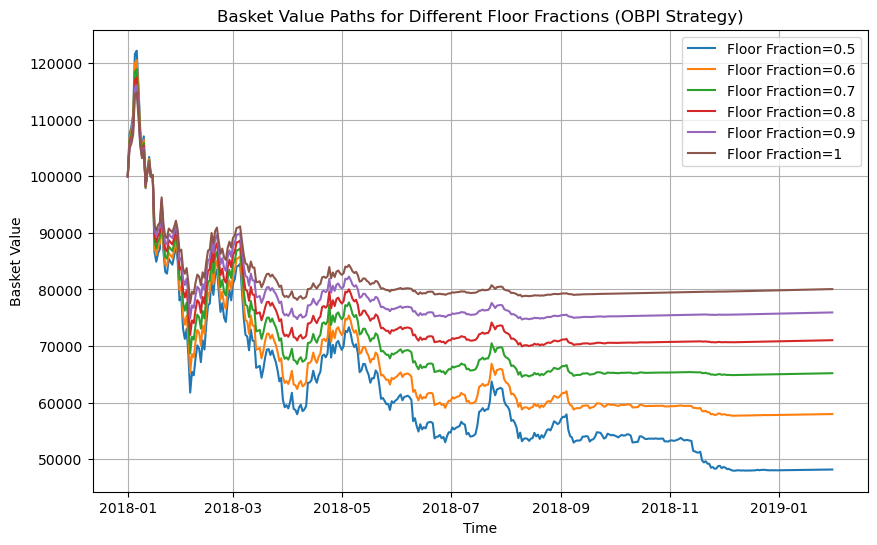

In [160]:
# Plot for the different floor levels

plotted_floors = set()  # To track already plotted floor fractions
plt.figure(figsize=(10, 6))

# Loop through the OBPI results and plot for unique floor fractions
for floor_fraction, df in obpi_results.items():
    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction}')
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Different Floor Fractions (OBPI Strategy)')
plt.grid(True)
plt.legend()
plt.show()

In [161]:
# Find the best floor level wrt final value

max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (floor_fraction), df in obpi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Floor Fraction = {best_params}")

Maximum Basket Value: [80069.41653135]
Best Parameters: Floor Fraction = 1


## Buy and Hold

### Run the strategy

In [162]:
def buy_and_hold_strategy(risky_asset, riskless_rate, allocation_ratio, initial_investment):
    """
    Implements a simple B&H strategy where the portfolio is split at the beginning
    and the return is calculated iteratively using a for loop.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_rate (array-like): Weekly rates of the risk-free asset (e.g., T-Bill).
        allocation_ratio (float): The ratio of the portfolio to allocate to the risky asset (60% for BTC, 40% for T-Bill).
        initial_investment (float): Initial total portfolio value.

    Returns:
        pd.DataFrame: Portfolio values for each week.
    """
    # Initial allocation
    btc_value = initial_investment * allocation_ratio
    t_bill_value = initial_investment * (1 - allocation_ratio)
    portfolio_values = []

    # Iterate over the time period
    for i in range(1, len(risky_asset)):
        # Calculate BTC return for the current week
        btc_weekly_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
        btc_value *= (1 + btc_weekly_return)

        # Calculate T-Bill return for the current week (rate-based)
        t_bill_weekly_return = riskless_rate[i] / 100 / 252  # adjust as needed (52 for weekly, 252 for daily)
        t_bill_value *= (1 + t_bill_weekly_return)

        # Store portfolio value
        portfolio_values.append(btc_value + t_bill_value)

    # Convert portfolio values to a DataFrame
    portfolio_df = pd.DataFrame(portfolio_values, columns=["Total Portfolio Value"])

    return portfolio_df

def plot_allocation_strategy(portfolio_df, dates):
    """
    Plots the portfolio values over time.

    Parameters:
        portfolio_df (pd.DataFrame): DataFrame containing the portfolio values.
        dates (pd.DatetimeIndex): Dates corresponding to the portfolio values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_df['Total Portfolio Value'], label='Total Portfolio Value', color='blue')
    plt.title("60/40 Allocation Strategy Portfolio Value")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()

In [163]:
initial_investment = 100000  # Example initial investment
allocation_ratio = 0.6  # 60% allocation to BTC

buy_and_hold_results = buy_and_hold_strategy(btc_array, t_bill_array, allocation_ratio, initial_investment)

buy_and_hold_results.head()

,Total Portfolio Value
0,105822.850667
1,106786.717628
2,108538.300207
3,116581.507494
4,117012.033345


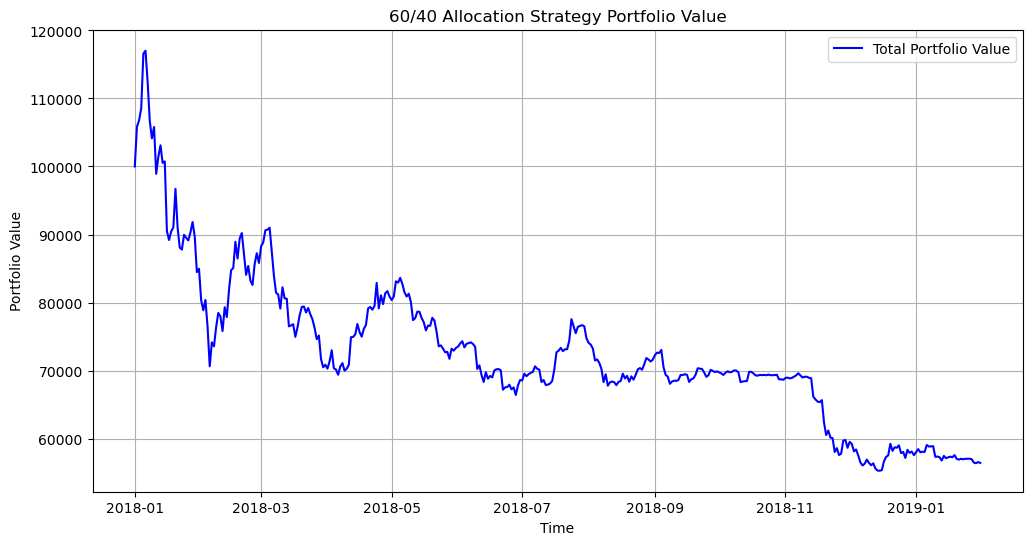

In [164]:
# Create a DataFrame for the initial investment with the same index as the portfolio_df
initial_investment_df = pd.DataFrame([initial_investment], columns=['Total Portfolio Value'], index=[btc_daily[start_date:end_date].index[0]]) # need to adjust

# Concatenate the initial investment DataFrame with the portfolio_df
buy_and_hold_df = pd.concat([initial_investment_df, buy_and_hold_results]).reset_index(drop=True)

# Plot the results
plot_allocation_strategy(buy_and_hold_df, btc_daily[start_date:end_date].index)

## Comparison of the three strategies

In [165]:
btc_array_base_100 = btc_array / btc_array[0]
btc_array_base_100 = btc_array_base_100 * 100

In [166]:
def performance(portfolio_values):
    
    # Calculate annualized return
    num_days = len(portfolio_values) - 1
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    annualized_return = (1 + total_return) ** (252 / num_days) - 1 if num_days > 0 else 0

    # Calculate daily returns
    daily_returns = portfolio_values.pct_change().dropna()

    # Calculate annualized volatility
    annualized_volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0

    # Calculate Sharpe ratio (risk-free rate = 0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    # Calculate Sortino ratio
    downside_returns = daily_returns[daily_returns < 0]
    downside_risk = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = annualized_return / downside_risk if downside_risk != 0 else np.nan

    # Calculate VaR 5%
    var_5 = np.percentile(daily_returns, 5) if len(daily_returns) > 0 else np.nan

    # Calculate Expected Shortfall 5%
    es_5 = daily_returns[daily_returns <= var_5].mean() if len(daily_returns[daily_returns <= var_5]) > 0 else np.nan

    # Calculate skewness
    skewness = daily_returns.skew() if len(daily_returns) > 0 else np.nan

    # Calculate max drawdown (in percentage)
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min() * 100 if len(drawdown) > 0 else 0

    # Calculate Information Ratio (assuming btc_array_base_100 is defined globally)
    btc_returns = pd.Series(btc_array_base_100.flatten()).pct_change().dropna()
    excess_returns = np.array(daily_returns) - btc_returns
    information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

    return (annualized_return, annualized_volatility, sharpe_ratio, sortino_ratio,
            var_5, es_5, skewness, max_drawdown, information_ratio)

def turnover(strategy_results):
    weights = strategy_results['Risky Weights']
    return np.sum(np.abs(np.diff(weights)))*100
    
# Assuming cppi_results, obpi_results, buy_and_hold_df, and btc_array_base_100 are defined
# CPPI Strategy
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = pd.Series(cppi_strategy_results['Basket Value']).apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
cppi_metrics = performance(cppi_portfolio_values)
cppi_turnover = turnover(cppi_strategy_results)

# OBPI Strategy
obpi_strategy_results = obpi_results[1]
obpi_portfolio_values = pd.Series(obpi_strategy_results['Basket Value']).apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
obpi_metrics = performance(obpi_portfolio_values)
obpi_turnover = turnover(obpi_strategy_results)

# Buy-and-Hold Strategy
bnh_portfolio_values = buy_and_hold_df['Total Portfolio Value'].apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
bnh_metrics = performance(bnh_portfolio_values)
bnh_turnover = 0

# Print results
print(f"CPPI Annualized Return: {cppi_metrics[0]:.2%}")
print(f"CPPI Annualized Volatility: {cppi_metrics[1]:.2%}")
print(f"CPPI Sharpe Ratio: {cppi_metrics[2]:.2f}")
print(f"CPPI Sortino Ratio: {cppi_metrics[3]:.2f}")
print(f"CPPI VaR 5%: {cppi_metrics[4]:.2%}")
print(f"CPPI Expected Shortfall 5%: {cppi_metrics[5]:.2%}")
print(f"CPPI Skewness: {cppi_metrics[6]:.2f}")
print(f"CPPI Turnover: {cppi_turnover.item():.2f}%")
print(f"CPPI Max Drawdown: {cppi_metrics[7]:.2f}%")
print(f"CPPI Information Ratio: {cppi_metrics[8]:.2f}")
print("")

print(f"OBPI Annualized Return: {obpi_metrics[0]:.2%}")
print(f"OBPI Annualized Volatility: {obpi_metrics[1]:.2%}")
print(f"OBPI Sharpe Ratio: {obpi_metrics[2]:.2f}")
print(f"OBPI Sortino Ratio: {obpi_metrics[3]:.2f}")
print(f"OBPI VaR 5%: {obpi_metrics[4]:.2%}")
print(f"OBPI Expected Shortfall 5%: {obpi_metrics[5]:.2%}")
print(f"OBPI Skewness: {obpi_metrics[6]:.2f}")
print(f"OBPI Turnover: {obpi_turnover.item():.2f}%")
print(f"OBPI Max Drawdown: {obpi_metrics[7]:.2f}%")
print(f"OBPI Information Ratio: {obpi_metrics[8]:.2f}")
print("")

print(f"B&H Annualized Return: {bnh_metrics[0]:.2%}")
print(f"B&H Annualized Volatility: {bnh_metrics[1]:.2%}")
print(f"B&H Sharpe Ratio: {bnh_metrics[2]:.2f}")
print(f"B&H Sortino Ratio: {bnh_metrics[3]:.2f}")
print(f"B&H VaR 5%: {bnh_metrics[4]:.2%}")
print(f"B&H Expected Shortfall 5%: {bnh_metrics[5]:.2%}")
print(f"B&H Skewness: {bnh_metrics[6]:.2f}")
print(f"B&H Turnover: {bnh_turnover:.2f}%")
print(f"B&H Max Drawdown: {bnh_metrics[7]:.2f}%")
print(f"B&H Information Ratio: {bnh_metrics[8]:.2f}")

CPPI Annualized Return: -12.91%
CPPI Annualized Volatility: 16.82%
CPPI Sharpe Ratio: -0.77
CPPI Sortino Ratio: -0.68
CPPI VaR 5%: -0.79%
CPPI Expected Shortfall 5%: -2.78%
CPPI Skewness: -1.44
CPPI Turnover: 348.84%
CPPI Max Drawdown: -33.12%
CPPI Information Ratio: 0.93

OBPI Annualized Return: -13.22%
OBPI Annualized Volatility: 18.80%
OBPI Sharpe Ratio: -0.70
OBPI Sortino Ratio: -0.61
OBPI VaR 5%: -1.89%
OBPI Expected Shortfall 5%: -3.51%
OBPI Skewness: -1.09
OBPI Turnover: 443.65%
OBPI Max Drawdown: -32.46%
OBPI Information Ratio: 1.01

B&H Annualized Return: -30.58%
B&H Annualized Volatility: 30.75%
B&H Sharpe Ratio: -0.99
B&H Sortino Ratio: -1.21
B&H VaR 5%: -3.46%
B&H Expected Shortfall 5%: -5.10%
B&H Skewness: -0.44
B&H Turnover: 0.00%
B&H Max Drawdown: -52.75%
B&H Information Ratio: 0.94


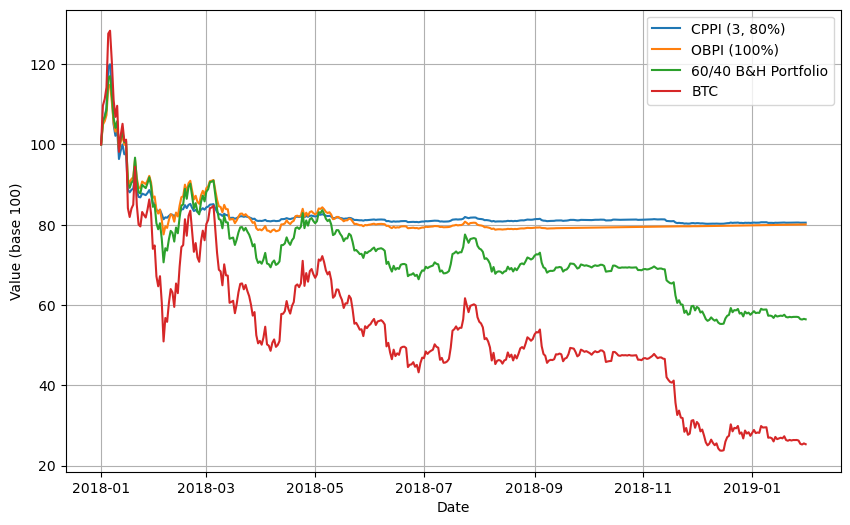

In [167]:
plt.figure(figsize=(10, 6))

# Plot CPPI results
plt.plot(cppi_results[(3, 0.8)]['Basket Value']/1000, label='CPPI (3, 80%)')

# Plot OBPI results
plt.plot(obpi_results[1]['Basket Value']/1000, label='OBPI (100%)')

# Plot B&H results
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, buy_and_hold_df['Total Portfolio Value']/1000, label='60/40 B&H Portfolio')

# Plot BTC prices as base 100,000
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, btc_array_base_100, label='BTC')

# Add title and labels
#plt.title('Comparison of Basket Value, CPPI, and 60/40 Portfolio')
plt.xlabel('Date')
plt.ylabel('Value (base 100)')
plt.legend()
plt.grid(True)
plt.show()

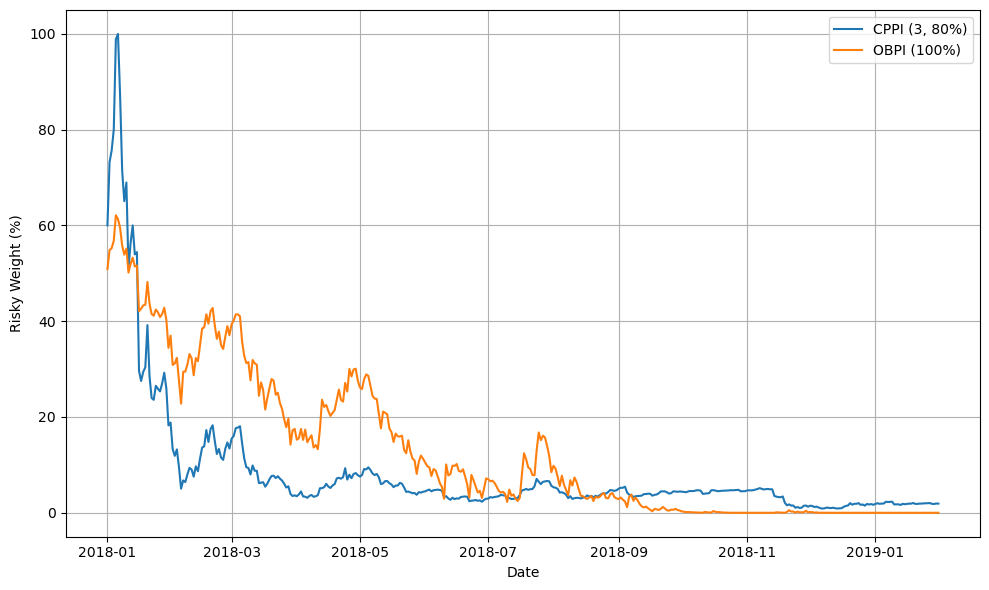

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(cppi_results[(3, 0.8)]['Risky Weights']*100, label='CPPI (3, 80%)')
plt.plot(obpi_results[(1)]['Risky Weights']*100, label='OBPI (100%)')
plt.xlabel('Date')
plt.ylabel('Risky Weight (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()